In [179]:
from __future__ import print_function, division
import numpy as np
import time
import torch
import pickle
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [120]:
# CUDA for Pytorch
# print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device ='cpu'

In [121]:
seq_data = RNASeqDataset(device=device)
print(f'dataset allocated on {device}')
lengths = torch.zeros(len(seq_data),10).long()
features = torch.zeros(len(seq_data),445,10)
for i in range(len(seq_data)):
    lengths[i] = seq_data[i]['lengths']
    features[i] = seq_data[i]['features']
# lengths = np.array(lengths)
print(lengths.shape, features.shape)

dataset allocated on cpu
torch.Size([1638, 10]) torch.Size([1638, 445, 10])


## Occurrence of bond types

In [68]:
bt_dict = {classname: 0 for classname in np.arange(0,11)}
btypes = features[:,:,6].squeeze().long()
for i in range(len(seq_data)):
    bt = (btypes[i,:lengths[i,6].squeeze()]-1).view(-1,3)[:,2]
    for label in bt:
        bt_dict[label.item()] += 1
print(list(bt_dict.values()))

[9828, 11466, 3431, 2602, 2556, 2877, 3431, 2602, 11466, 9828, 11466]


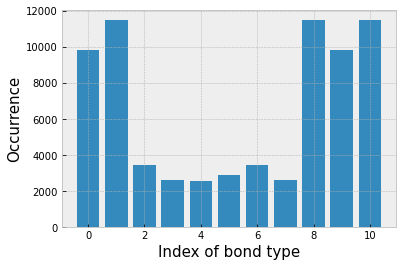

In [105]:
b_occ = plt.bar(list(bt_dict.keys()),height=list(bt_dict.values()))
plt.xlabel('Index of bond type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/bonds_occurr.pdf')
plt.show()

### Data visualzation

In [167]:
# One-hot encoding
labels = range(1,12)
lb = LabelBinarizer()
lb.fit(labels)

b_maxlen = int(max(lengths[:,6])/3)
Xb = torch.zeros(len(seq_data),b_maxlen*11)
for i in range(len(seq_data)):
    Xb[i,:int(lengths[i,6]/3)*11] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,6].squeeze()].view(-1,3)[:,2]).reshape(-1,))
print(Xb.shape)

torch.Size([1638, 517])


PC1 variance fraction explained = 0.1816435285727928
PC2 variance fraction explained = 0.12095760578555012


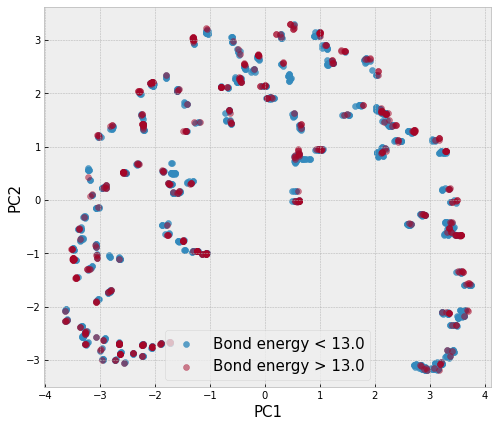

In [168]:
# PCA
pca = decomposition.PCA()
Xb_pca = pca.fit_transform(Xb)
varb = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {varb[0]}")
print(f"PC2 variance fraction explained = {varb[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xb_pca[features[:,0,9]<13,0],Xb_pca[features[:,0,9]<13,1],alpha=0.8,label='Bond energy < 13.0')
plt.scatter(Xb_pca[features[:,0,9]>=13,0],Xb_pca[features[:,0,9]>=13,1],alpha=0.5,label='Bond energy > 13.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/bondsPCA.pdf')
plt.show()

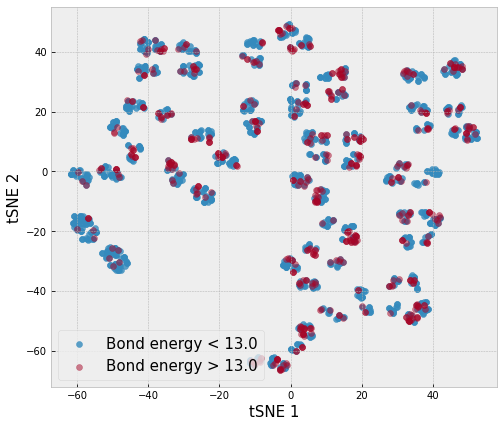

In [182]:
# t-SNE
Xb_tSNE = manifold.TSNE().fit_transform(Xb)
fig = plt.figure(figsize=(8,7))
plt.scatter(Xb_tSNE[features[:,0,9]<13,0],Xb_tSNE[features[:,0,9]<13,1],alpha=0.8,label='Bond energy < 13.0')
plt.scatter(Xb_tSNE[features[:,0,9]>=13,0],Xb_tSNE[features[:,0,9]>=13,1],alpha=0.5,label='Bond energy > 13.0')
plt.xlabel("tSNE 1", fontsize=15)
plt.ylabel("tSNE 2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/bondsTSNE.pdf')
plt.show()

## Occurrence of angle types

In [169]:
at_dict = {classname: 0 for classname in np.arange(0,12)}
atypes = features[:,:,7].squeeze().long()
for i in range(len(seq_data)):
    at = (atypes[i,:lengths[i,7].squeeze()]-1).view(-1,4)[:,3]
    for label in at:
        at_dict[label.item()] += 1
print(list(at_dict.values()))

[2602, 2556, 3431, 2877, 2602, 3431, 9828, 11466, 9828, 9828, 11466, 9828]


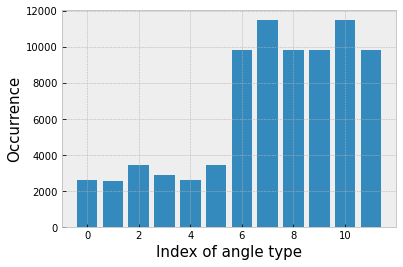

In [170]:
a_occ = plt.bar(list(at_dict.keys()),height=list(at_dict.values()))
plt.xlabel('Index of angle type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/angles_occurr.pdf')
plt.show()

In [171]:
# One-hot encoding
labels = range(1,13)
lb = LabelBinarizer()
lb.fit(labels)

a_maxlen = int(max(lengths[:,7])/4)
Xa = torch.zeros(len(seq_data),a_maxlen*12)
for i in range(len(seq_data)):
    Xa[i,:int(lengths[i,7]/4)*12] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,7].squeeze()].view(-1,4)[:,3]).reshape(-1,))
print(Xa.shape)

torch.Size([1638, 624])


PC1 variance fraction explained = 0.18054261938834218
PC2 variance fraction explained = 0.11221543759687905


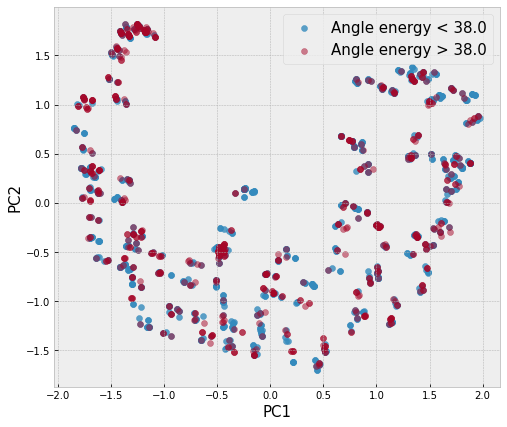

In [173]:
pca = decomposition.PCA()
Xa_pca = pca.fit_transform(Xa)
vara = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {vara[0]}")
print(f"PC2 variance fraction explained = {vara[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xa_pca[features[:,1,9]<38,0],Xa_pca[features[:,1,9]<38,1],alpha=0.8,label='Angle energy < 38.0')
plt.scatter(Xa_pca[features[:,1,9]>=38,0],Xa_pca[features[:,1,9]>=38,1],alpha=0.5,label='Angle energy > 38.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/anglesPCA.pdf')
plt.show()

## Index of dihedral type

In [72]:
dt_dict = {classname: 0 for classname in np.arange(0,25)}
dtypes = features[:,:,8].squeeze().long()
for i in range(len(seq_data)):
    dt = (dtypes[i,:lengths[i,8].squeeze()]-1).view(-1,5)[:,4]
    for label in dt:
        dt_dict[label.item()] += 1
print(list(dt_dict.values()))

[3431, 3431, 2602, 2602, 2602, 3431, 2602, 2602, 3431, 2877, 2877, 2556, 2556, 2258, 2981, 2388, 2201, 9828, 9828, 9828, 11466, 9828, 9828, 9828, 9828]


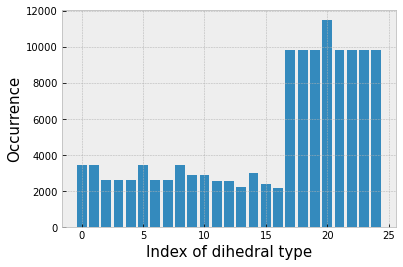

In [101]:
d_occ = plt.bar(list(dt_dict.keys()),height=list(dt_dict.values()))
plt.xlabel('Index of dihedral type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/tors_occurr.pdf')
plt.show()

In [175]:
# One-hot encoding
labels = range(1,26)
lb = LabelBinarizer()
lb.fit(labels)

d_maxlen = int(max(lengths[:,8])/5)
Xd = torch.zeros(len(seq_data),d_maxlen*25)
for i in range(len(seq_data)):
    Xd[i,:int(lengths[i,8]/5)*25] = torch.from_numpy(lb.transform(btypes[i,:lengths[i,8].squeeze()].view(-1,5)[:,4]).reshape(-1,))
print(Xd.shape)

torch.Size([1638, 2225])


PC1 variance fraction explained = 0.2260475236111561
PC2 variance fraction explained = 0.1169647363560614


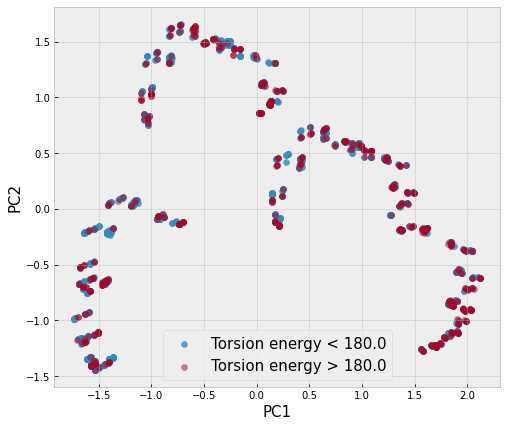

In [178]:
pca = decomposition.PCA()
Xd_pca = pca.fit_transform(Xd)
vard = pca.explained_variance_ratio_
print(f"PC1 variance fraction explained = {vard[0]}")
print(f"PC2 variance fraction explained = {vard[1]}")
fig = plt.figure(figsize=(8,7))
plt.scatter(Xd_pca[features[:,2,9]<180,0],Xd_pca[features[:,2,9]<180,1],alpha=0.8,label='Torsion energy < 180.0')
plt.scatter(Xd_pca[features[:,2,9]>=180,0],Xd_pca[features[:,2,9]>=180,1],alpha=0.5,label='Torsion energy > 180.0')
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images/torsionsPCA.pdf')
plt.show()

## Index of atom type

In [76]:
atom_dict = {classname: 0 for classname in np.arange(1,12)}
atom_types = features[:,:,0].squeeze().long()
for i in range(len(seq_data)):
    att = atom_types[i,:lengths[i,0].squeeze()]
    for label in att:
        atom_dict[label.item()] += 1
print(list(atom_dict.values()))

[11466, 11466, 9828, 11466, 11466, 3431, 3431, 2602, 2602, 2556, 2877]


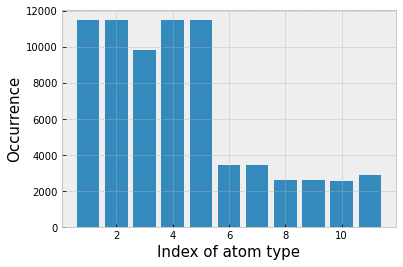

In [102]:
at_occ = plt.bar(list(atom_dict.keys()),height=list(atom_dict.values()))
plt.xlabel('Index of atom type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/atoms_occurr.pdf')
plt.show()

## Residue type

In [88]:
res_dict = {classname: 0 for classname in np.arange(1,5)}
res_types = features[:,:,1].squeeze().long()
for i in range(len(seq_data)):
    res = res_types[i,:lengths[i,1].squeeze()]
    for label in res:
        res_dict[label.item()] += 1
print(list(res_dict.values()))

[3431, 2602, 2877, 2556]


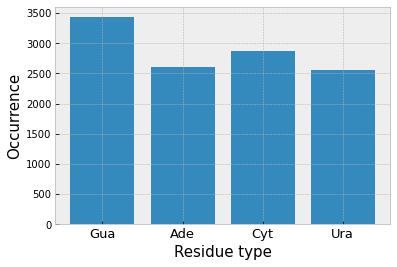

In [103]:
res_occ = plt.bar(list(res_dict.keys()),height=list(res_dict.values()))
plt.xlabel('Residue type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.xticks(list(res_dict.keys()),['Gua','Ade','Cyt','Ura'],fontsize=13)
plt.savefig('Images/res_occurr.pdf')
plt.show()